**Group number**  
3

**Group members**  
Alexander Stoustrup  
Mathias Tyranski  
Benjamin Simonsen

In [1]:
import numpy as np
from scipy.optimize import minimize
import scipy.signal as si
import sympy as sp
import control as ct
from typing import List
from sympy.plotting import plot
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Math, Image

def eq_disp(varstring, expr, unit=""):
    display(Latex(f"${varstring}={sp.latex(expr)} \: {unit}$"))
    
def reduce_feedback(G_fwd, G_bwd):
    """Assumes feedback is deducted from signal, if not
    change sign of feedback"""
    return sp.simplify(G_fwd/(1+G_fwd*G_bwd))

def RHarray(coeffs: List):
    # first 2 rows from coefficients
    n = len(coeffs)
    arr = sp.zeros(n, n//2+2)
    i = 0
    for i in range(0,n,2):
        arr[0, i//2] = coeffs[i]
    for i in range(1,n,2):
        arr[1, i//2] = coeffs[i]

    for j in range(2, arr.shape[0]):
        for i in range(arr.shape[1]-1):
            a0 = arr[j-2,0]
            a3 = a1 = arr[j-1,i+1]
            a1 = arr[j-1,0]
            a2 = arr[j-2,i+1]
            arr[j, i] = (a1*a2-a0*a3)/a1
    return arr

# P9.21

In [2]:
K, s = sp.symbols('K, s')
L = K/(s*(s+1)*(s+4))
eq_disp('L(s)', L)
T = reduce_feedback(L, 1)
eq_disp('T(s)', T)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## a) Bode plot

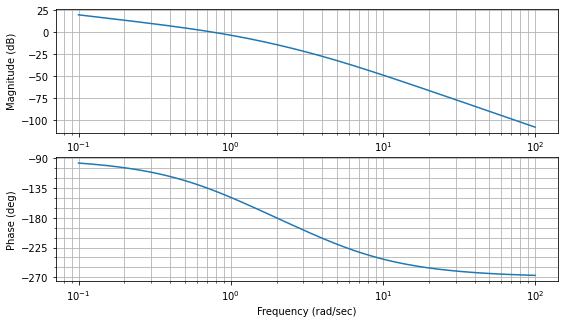

In [3]:
K = 4
s = ct.tf('s')
sys = K/(s*(s+1)*(s+4))

fig, ax = plt.subplots(figsize=(9, 5))
mag, phase, omega = ct.bode(sys, dB=True)

## b) Gain margin

Rewriting the loop transfer function to the frequency domain on the following form to be able to extract $\tau_1$ and $\tau_2$
$$L(j\omega) = \frac{K}{j \omega\left(j \omega \tau_1+1\right)\left(j \omega \tau_2+1\right)}$$

In [4]:
K, s, j, omega = sp.symbols('K, s, j, omega')
L = K*(1/4)/(j*omega*(j*omega+1)*(j*omega/4+1))
eq_disp('L(s)', L)

<IPython.core.display.Latex object>

With

In [5]:
tau1 = 1/4
tau2 = 1
K = 4
eq_disp('\\tau_1', tau1)
eq_disp('\\tau_2', tau2)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Evaluating the gain margin by
\begin{equation}
G.M.=20log\left(\left[\frac{K \tau_1 \tau_2}{\tau_1+\tau_2}\right]^{-1}\right)
\label{eq:GM}
\end{equation}

In [6]:
GM_K4 = (20*sp.log((K*0.25*tau1*tau2/(tau1 + tau2))**(-1), 10)).evalf()
eq_disp('G. M.(K=4)', round(GM_K4,1), 'dB')

<IPython.core.display.Latex object>

## c) K providing gain margin of 12 dB

Eq. \ref{eq:GM} is solved for $K$ with a gain margin of $12 dB$
$$12 dB=20log\left(\left[\frac{K \tau_1 \tau_2}{\tau_1+\tau_2}\right]^{-1}\right)$$

In [7]:
K = sp.symbols('K')
K_12 = sp.solve(20*sp.log((K*0.25*tau1*tau2/(tau1 + tau2))**(-1), 10) - 12, K)[0]
eq_disp('K(G.M.=12 dB)', round(K_12, 1))

<IPython.core.display.Latex object>

## d) K for steady-state error of 25 % of the magnitude $A$ for ramp input

In [8]:
K, s, A = sp.symbols('K, s, A')
L = K/(s*(s+1)*(s+4))
eq_disp('L(s)', L)

<IPython.core.display.Latex object>

In [9]:
R = A*1/s**2
E = sp.simplify(R/(1 + L))
eq_disp('E(s)', E)

<IPython.core.display.Latex object>

$$e_{ss}=\lim_{s \to 0} sE(s)$$

In [10]:
e_ss = sp.limit(sp.simplify(s*E), s, 0)
eq_disp('e_{ss}', e_ss)

<IPython.core.display.Latex object>

With
$$e_{ss} = 0.25A$$

In [11]:
K_25p = sp.solve(e_ss - 0.25*A, K)[0]
eq_disp('K(e_{ss}=0.25A)', K_25p)

<IPython.core.display.Latex object>

### Checking if this K results in a stable system

Finding the coefficients of the denominator

In [12]:
p, q = T.as_numer_denom()

coeffs = sp.Poly(q, s).coeffs()
eq_disp('q(s)', sp.Poly(q, s))
for i, k in enumerate(coeffs):
    display(Latex(f"${f's^{len(coeffs)-1-i}'}: {sp.latex(k)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Finding Routh-Hurwitz array

In [13]:
arr = RHarray(coeffs)
arr

Matrix([
[      1, 4, 0, 0],
[      5, K, 0, 0],
[4 - K/5, 0, 0, 0],
[      K, 0, 0, 0]])

So when the two roots lie on the imaginary axis the gain is

In [14]:
K_mstable = sp.solve(arr[2,0], K)[0]
eq_disp('K', K_mstable)

<IPython.core.display.Latex object>

For $K<20$ the system will be stable so this gain can be utilized and achieve acceptable performance

# AP9.11

In [15]:
s = sp.symbols('s')
t = sp.symbols('t', positive=True)
T_delay = 1 #s
PO_max = 0.1
Gc = 5/(s*(s + 10))
G = sp.exp(-s*T_delay)
T = reduce_feedback(Gc*G, 1)
eq_disp('G_c(s)', Gc)
eq_disp('G(s)', G)
eq_disp('T(s)', T)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Ignoring the time delay

In [16]:
T_ndelay = reduce_feedback(Gc, 1)
eq_disp('T(s)', T_ndelay)

<IPython.core.display.Latex object>

In [17]:
R = 1/s
Y_ndelay = R*T_ndelay
y_ndelay = sp.inverse_laplace_transform(Y_ndelay, s, t)
eq_disp('y(t)', y_ndelay)

<IPython.core.display.Latex object>

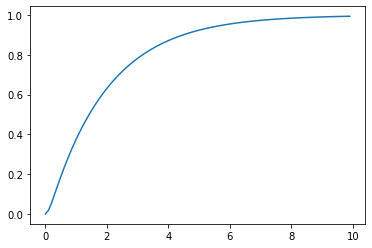

In [18]:
y_plot = sp.lambdify(t, y_ndelay)
t_span = np.r_[0:10:0.1]
plt.plot(t_span, y_plot(t_span))

With the time delay

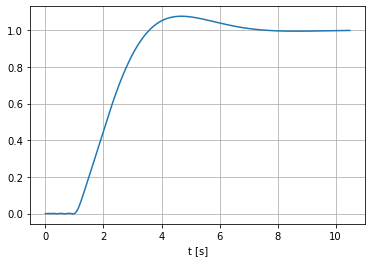

In [19]:
# Make padé approximation of time delay
# 10th order approximation
n_pade = 10
num_pade, den_pade = ct.pade(T_delay, n_pade)
H_pade = ct.tf(num_pade, den_pade)

s = ct.tf('s')
Gc = 5/(s*(s + 10))

# Connect Gc and time delay in series to get loop function
L = ct.series(Gc, H_pade)

# Reduce feedback loop
T = ct.feedback(L, 1)

# Get step response
t, y = ct.step_response(T)

# Plot
plt.plot(t, y)
plt.xlabel('t [s]')
plt.grid ()

The steadu state error is approximated

In [20]:
e_ss = 1 - y[-1]
eq_disp('e_{ss}', round(e_ss,2))

<IPython.core.display.Latex object>

The percent overshoot
$$P.O. = \frac{y(T_p) - y(\infty)}{y(\infty)}$$
is found

In [22]:
PO = (np.max(y) - 1)/1
eq_disp('P.O.', round(PO,3)*100, '\\%')

<IPython.core.display.Latex object>

So the percent overshoot and steady state error specifications are satisfied.

Next, we find the gain margin, phase margin and cut-off frequencies of each of them. The time delay results in a phase shift so we find the margins for the controller transfer function

In [73]:
gm, pm, wcg, wcp = ct.margin(Gc)

We get the phase margin and the cut-off frequency for the phase margin

In [75]:
eq_disp('\\phi_{pm}', round(pm,1), '^\\circ')
eq_disp('\\omega_{cp}', round(wcp,2), 'rad/s')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The critical time delay is
$$T_c = \frac{\phi_{pm}}{\omega_{cp}}$$

In [77]:
T_c = pm/(wp*180/np.pi)
eq_disp('T_c', round(T_c,4))

<IPython.core.display.Latex object>

So
$$T \leq T_c = \frac{\phi_{pm}}{\omega_{cp}}$$

The time delay $e^{-sT}$ results in a phase shift
$$\phi(\omega) = -\omega T$$

Text(0, 0.5, '$\\phi_{pm}$ $[^\\circ]$')

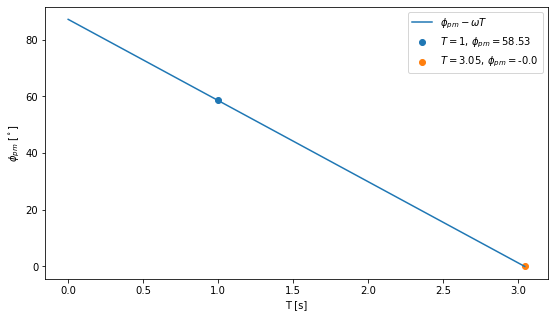

In [107]:
phi = lambda T_d: T_d*wp*180/np.pi
T_span = np.r_[0:5:T_c]

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(T_span, pm-phi(T_span))
ax.scatter(T_delay, pm-phi(T_delay))
ax.scatter(T_c, pm-phi(T_c))
ax.legend(['$\phi_{pm}-\omega T$', f'$T={round(T_delay,2)}$, ' + '$\phi_{pm}=$' + f'{round(pm-phi(T_delay),2)}', f'$T={round(T_c,2)}$, ' + '$\phi_{pm}=$' + f'{round(pm-phi(T_c),2)}'])
ax.set_xlabel('T [s]')
ax.set_ylabel('$\phi_{pm}$ $[^\circ]$')

# DP9.1

## a)

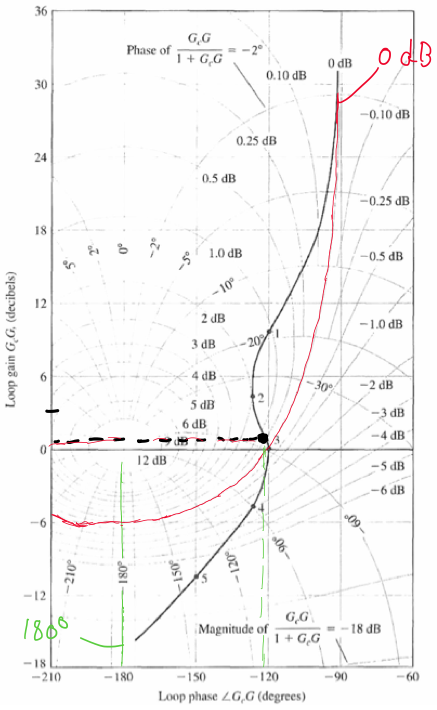

In [108]:
Image('Gain and phase margin.png', width='400px')

From the plot the gain and phase margins are read

In [109]:
GM = 6
PM = 60
eq_disp('G.M.', GM, 'dB')
eq_disp('P.M.', PM, '^\\circ')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>